In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from nltk.tokenize import WordPunctTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv(r"datasets_72366_159129_BuzzFeed_fake_news_content.csv")
dff = pd.read_csv(r"datasets_72366_159129_BuzzFeed_real_news_content.csv")

In [4]:
# df.head()
# dff.head()

In [5]:
#adding labels
df['label'] = 'fake'
dff['label'] = 'real'

In [6]:
#selecting important columns
df = df[['title', 'text', 'url', 'authors', 'source', 'meta_data', 'label']]
dff = dff[['title', 'text', 'url', 'authors', 'source', 'meta_data', 'label']]

In [7]:
print(df.shape, 
     dff.shape)

(91, 7) (91, 7)


In [8]:
#combining the datasets
df = pd.concat([df, dff])
df.reset_index(drop = True,inplace = True)

In [9]:
print(df.shape)
print(df.columns)

(182, 7)
Index(['title', 'text', 'url', 'authors', 'source', 'meta_data', 'label'], dtype='object')


In [10]:
# df.head()

## PREPROCESSING

In [11]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [12]:
df['title'] = df['title'].apply(tweet_cleaner)
df['text'] = df['text'].apply(tweet_cleaner)
df['meta_data'] = df['meta_data'].apply(tweet_cleaner)

In [13]:
def all_X(row):
    try:
        return row['title']+" "+row["text"]+" "+row["meta_data"]
    except: print("error", row)
        #giving out the error fields.    

In [14]:
df["all_X"]= df.apply(all_X,axis=1)

In [15]:
df = df[['all_X', 'label']]

In [16]:
print(df.columns)

Index(['all_X', 'label'], dtype='object')


In [17]:
#Assign text to X variable and labels to y

X = df.all_X
y = df.label

In [18]:
#Intialize Count Vectorizer
count_vec = CountVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2),
                           min_df = 3)
#Fit Count Vectorizer
dtm_cv = count_vec.fit_transform(X)
#Convert it to a pandas data frame
df_cv = pd.DataFrame(dtm_cv.toarray(), columns=count_vec.get_feature_names())

In [19]:
df_cv.head()

,abandon,abandoned,abc,abc abcnews,abc news,abcnews,abcnews abcnews,abcnews card,abcnews com,abcnews iphone,...,young,young adults,younger,zde,zde rd,zero,zuthf,zuthf dco,zyx,zyx bqy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_cv.shape

(182, 4191)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_cv, y, test_size = 0.3, random_state = 0)

In [22]:
print(x_train.shape,
     x_test.shape)

(127, 4191) (55, 4191)


### Naive Bayes

In [23]:
#Initialize model
model = MultinomialNB()
#Fit model with df_cv and y
model.fit(x_train, y_train)
#score the model
y_pred = model.predict(x_test)
accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv=10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(accuracy.mean()*100))

Model accuracy : 85.45%
cross validation : 84.23%


In [24]:
# print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.81      0.93      0.87        28
        real       0.91      0.78      0.84        27

    accuracy                           0.85        55
   macro avg       0.86      0.85      0.85        55
weighted avg       0.86      0.85      0.85        55



### Boosting

In [25]:
gbc = GradientBoostingClassifier(max_depth = 2)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_test)
accuracy = cross_val_score(estimator = gbc, X = x_train, y = y_train, cv=10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(accuracy.mean()*100))

Model accuracy : 83.64%
cross validation : 84.94%


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.77      0.96      0.86        28
        real       0.95      0.70      0.81        27

    accuracy                           0.84        55
   macro avg       0.86      0.83      0.83        55
weighted avg       0.86      0.84      0.83        55



### Decision Tree

In [27]:
dTree = DecisionTreeClassifier()
dTree.fit(x_train,y_train)
y_pred = dTree.predict(x_test)
accuracy = cross_val_score(estimator = dTree, X = x_train, y = y_train, cv = 10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(accuracy.mean()*100))

Model accuracy : 72.73%
cross validation : 85.77%


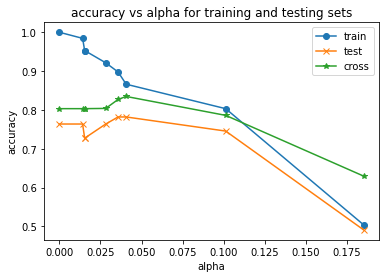

In [28]:
path = dTree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas

trees = []
for ccp_alpha in ccp_alphas:
    tree  = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    tree.fit(x_train, y_train)
    trees.append(tree)
    
train_score = [tree.score(x_train, y_train) for tree in trees]
test_score = [tree.score(x_test, y_test) for tree in trees]
cross_val_scores = [cross_val_score(estimator = tree, X = x_train, y = y_train, cv = 10).mean() for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas, train_score, marker = 'o', label = 'train')
ax.plot(ccp_alphas, test_score, marker = 'x', label = 'test')
ax.plot(ccp_alphas, cross_val_scores, marker = '*', label = 'cross_val')
plt.legend(['train', 'test', 'cross'])
plt.show()

In [29]:
dTree = DecisionTreeClassifier(ccp_alpha = 0.042)
dTree.fit(x_train,y_train)
y_pred = dTree.predict(x_test)
accuracy = cross_val_score(estimator = dTree, X = x_train, y = y_train, cv = 10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(accuracy.mean()*100))

Model accuracy : 80.00%
cross validation : 85.06%


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.74      0.93      0.83        28
        real       0.90      0.67      0.77        27

    accuracy                           0.80        55
   macro avg       0.82      0.80      0.80        55
weighted avg       0.82      0.80      0.80        55



### Ada Boost

In [31]:
abc = AdaBoostClassifier(n_estimators = 50,learning_rate = 1)
abc.fit(x_train, y_train)
y_pred = abc.predict(x_test)
acuracy = cross_val_score(estimator = abc, X = x_train, y = y_train, cv = 10)
y_pred = abc.predict(x_test)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(acuracy.mean()*100))

Model accuracy : 83.64%
cross validation : 83.33%


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.79      0.93      0.85        28
        real       0.91      0.74      0.82        27

    accuracy                           0.84        55
   macro avg       0.85      0.83      0.83        55
weighted avg       0.85      0.84      0.83        55



### KNN

In [33]:
#neighbors randomly taken
knn = KNeighborsClassifier(n_neighbors = 7) 
knn.fit(x_train, y_train) 
y_pred = knn.predict(x_test)
accuracy = cross_val_score(estimator = knn, X = x_train, y = y_train, cv = 10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(accuracy.mean()*100))

Model accuracy : 63.64%
cross validation : 62.18%


Text(0, 0.5, 'Error Rate')

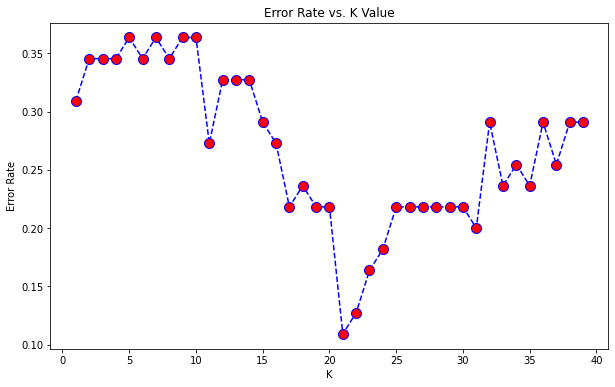

In [34]:
error_rate = []  
# Will take some time 
for i in range(1, 40): 
      
    knn = KNeighborsClassifier(n_neighbors = i) 
    knn.fit(x_train, y_train) 
    pred_i = knn.predict(x_test) 
    error_rate.append(np.mean(pred_i != y_test)) 

plt.figure(figsize =(10, 6)) 
plt.plot(range(1, 40), error_rate, color ='blue', 
                linestyle ='dashed', marker ='o', 
         markerfacecolor ='red', markersize = 10) 
  
plt.title('Error Rate vs. K Value') 
plt.xlabel('K') 
plt.ylabel('Error Rate') 

In [35]:
#error rate for k=1 is very high
#error rate is decreaing after k = 9

In [36]:
knn = KNeighborsClassifier(n_neighbors = 21) 
knn.fit(x_train, y_train) 
y_pred = knn.predict(x_test)
accuracy = cross_val_score(estimator = knn, X = x_train, y = y_train, cv=10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(acuracy.mean()*100))

Model accuracy : 89.09%
cross validation : 83.33%


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.84      0.96      0.90        28
        real       0.96      0.81      0.88        27

    accuracy                           0.89        55
   macro avg       0.90      0.89      0.89        55
weighted avg       0.90      0.89      0.89        55



### SVM

In [38]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.560, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.520, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.480, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.500, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.500, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.560, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.520, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.480, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   16.1s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [39]:
# print best parameter after tuning 
print(grid.best_params_) 
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.0001)


In [40]:
svm = SVC(C=100, gamma = 0.0001)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
accuracy = cross_val_score(estimator = svm, X = x_train, y = y_train, cv=10)
print("Model accuracy : {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
print("cross validation : {:0.2f}%".format(acuracy.mean()*100))

Model accuracy : 92.73%
cross validation : 83.33%
